<a href="https://colab.research.google.com/github/kostiantynvoskovtsov/masters-thesis/blob/main/td_denton_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries needed
import numpy as np
import pandas as pd
from IPython.display import display
# Filter and download quarterly GDP from Eurostat, then check whether data loaded correctly
def load_and_check(quarter_gdp):
    if quarter_gdp.shape[0] != 96: # number of rows(indexed as [0]) in the created pandas dataframe should match the amount of rows in .csv file
        print('Please check if data was loaded properly, different shape was expected.')
    else:
        print('Data loaded properly.')
    return quarter_gdp
url = "https://drive.google.com/uc?id=1B1fCC3A-KgQ1pcxIrLWlASulJLhnKBiQ&export=download"
quarter_gdp = pd.read_csv(url)
display(load_and_check(quarter_gdp))

Data loaded properly.


,Quarter,Quarter GDP
0,2000-Q1,1473
1,2000-Q2,1516
2,2000-Q3,1541
3,2000-Q4,1640
4,2001-Q1,1660
...,...,...
91,2022-Q4,9214
92,2023-Q1,9395
93,2023-Q2,9397
94,2023-Q3,9404


In [2]:
# Compute growth rates in log form, in order to observe changes over time and stabilise the variance
quarter_gdp['log Growth Rate'] = np.log(quarter_gdp['Quarter GDP'].astype(float))-np.log(quarter_gdp['Quarter GDP'].shift(1).astype(float))
quarter_gdp

,Quarter,Quarter GDP,log Growth Rate
0,2000-Q1,1473,NaN
1,2000-Q2,1516,0.028774
2,2000-Q3,1541,0.016356
3,2000-Q4,1640,0.062265
4,2001-Q1,1660,0.012121
...,...,...,...
91,2022-Q4,9214,0.003152
92,2023-Q1,9395,0.019454
93,2023-Q2,9397,0.000213
94,2023-Q3,9404,0.000745


In [3]:
#impute the median
quarter_gdp['log Growth Rate'] = quarter_gdp['log Growth Rate'].fillna(np.nanmedian(quarter_gdp['log Growth Rate']))
display(quarter_gdp)

,Quarter,Quarter GDP,log Growth Rate
0,2000-Q1,1473,0.023865
1,2000-Q2,1516,0.028774
2,2000-Q3,1541,0.016356
3,2000-Q4,1640,0.062265
4,2001-Q1,1660,0.012121
...,...,...,...
91,2022-Q4,9214,0.003152
92,2023-Q1,9395,0.019454
93,2023-Q2,9397,0.000213
94,2023-Q3,9404,0.000745


In [4]:
import statsmodels.api as sm
# Fit AR model to see whether there are patterns/correlations within growth rates
log_gr = quarter_gdp['log Growth Rate']
model = sm.tsa.arima.ARIMA(log_gr, order=(1,0,0))#why AR1?
fitted_model = model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:        log Growth Rate   No. Observations:                   96
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 213.210
Date:                Wed, 15 May 2024   AIC                           -420.420
Time:                        15:27:47   BIC                           -412.727
Sample:                             0   HQIC                          -417.310
                                 - 96                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0196      0.004      4.612      0.000       0.011       0.028
ar.L1          0.2630      0.064      4.082      0.000       0.137       0.389
sigma2         0.0007   7.98e-05      8.628      0.0

In [5]:
#Get residuals from the fitted ARIMA model
from IPython.display import display
fit_model_resid_df = pd.DataFrame(fitted_model.resid)
display(fit_model_resid_df)

,0
0,0.004243
1,0.008037
2,-0.005672
3,0.043502
4,-0.018713
...,...
91,-0.018595
92,0.004163
93,-0.019364
94,-0.013773


In [6]:
from scipy.stats import t

np.random.seed(24)  # Set a random seed for reproducibility

# Calculate the mean and standard deviation of the residuals from the fitted ARIMA model
mu = np.mean(fitted_model.resid)
sig = np.std(fitted_model.resid)

# Parameters for outliers
outlier_value = mu - 5 * sig  # Value for the outliers

# Set the degrees of freedom for the t-distribution
degrees_of_freedom = 5

# Initialize an array to store the generated residuals for Monte Carlo simulation
simulations = 1200
clean_simulations = 0
generated_residuals = np.ndarray((len(log_gr), 1000))

# Generate more than 1000 sets of residuals to account for the potential removal of some
i = 0
while clean_simulations < 1000:
    # Generate residuals (using t-distribution)
    resid_new = t.rvs(degrees_of_freedom, loc=mu, scale=sig, size=len(log_gr))

    # Introduce 10 controlled outliers at random locations
    outlier_indices = np.random.choice(range(len(resid_new)), size=10, replace=False)
    resid_new[outlier_indices] = outlier_value

    # Check for inf and NaN values
    if not (np.isnan(resid_new).any() or np.isinf(resid_new).any()):
        # Add the new residuals to the generated_residuals array if they are clean
        generated_residuals[:, clean_simulations] = resid_new
        clean_simulations += 1
    i += 1
    if i >= simulations:
        break

# Print the mean and standard deviation of the residuals
print("Mean of residuals:", mu)
print("Standard deviation of residuals:", sig)

# Display the generated residuals
gen_residuals_df = pd.DataFrame(generated_residuals)
display(gen_residuals_df)


Mean of residuals: -7.938739243559863e-06
Standard deviation of residuals: 0.02624602594821196


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.049945,-0.028061,-0.011725,-0.131238,-0.008865,0.010969,-0.131238,0.004566,0.002796,-0.021077,...,0.004717,-0.015026,-0.015779,-0.010414,-0.022087,-0.131238,-0.026850,0.038256,0.049884,0.006781
1,-0.026383,-0.009981,0.036224,-0.001144,0.008963,-0.131238,0.011021,-0.018511,0.018075,-0.026767,...,-0.038297,0.007372,0.010818,0.011645,0.016225,0.037705,-0.036672,-0.041141,0.016300,0.033435
2,-0.054543,-0.038056,-0.131238,-0.131238,-0.013446,0.092395,0.003274,0.010352,-0.020632,0.026793,...,0.014356,-0.070786,-0.068502,-0.019615,-0.028514,-0.026663,0.018973,0.037478,-0.008546,0.013462
3,0.001674,-0.008116,-0.007145,-0.033261,-0.131238,-0.041373,-0.028536,0.047118,-0.011895,0.022111,...,-0.013144,-0.038522,0.032519,-0.031532,-0.018712,0.001895,0.028713,0.011518,0.016766,0.026138
4,0.011209,0.038862,0.009970,0.022346,0.034092,0.007535,-0.000480,0.007943,-0.003229,-0.022060,...,0.040327,0.026510,-0.019563,0.042686,-0.131238,0.003212,-0.053916,-0.004769,-0.005993,0.014461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,-0.005447,-0.007697,0.006793,-0.005650,-0.025620,-0.038796,-0.131238,-0.131238,-0.019795,-0.131238,...,-0.131238,-0.048524,-0.006699,-0.014789,-0.131238,-0.131238,-0.131238,0.002673,0.051355,0.069528
92,-0.021379,0.029708,-0.131238,-0.001299,0.027245,0.046534,0.038373,0.055597,0.080296,0.013574,...,-0.028049,-0.092288,-0.043570,-0.131238,-0.033357,-0.024425,-0.000435,-0.004346,0.026822,-0.035455
93,0.021876,0.018998,0.000962,-0.027140,0.005328,0.037154,-0.041223,-0.006474,-0.131238,-0.006109,...,0.028601,0.028144,-0.041327,-0.010967,0.015601,-0.131238,-0.019765,-0.131238,-0.025572,0.032454
94,0.008692,-0.023556,-0.007063,-0.021126,0.045513,0.019804,-0.131238,-0.027554,-0.019095,-0.131238,...,-0.011220,-0.131238,-0.131238,0.006797,-0.004516,0.027035,-0.024038,0.029888,-0.057295,-0.012322


In [7]:
# Function to detect outliers using the IQR method
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    outliers = data[(data < Q1 - outlier_step) | (data > Q3 + outlier_step)]
    return outliers

# Assuming 'fitted_model.resid' is a pandas Series or numpy array
data = fitted_model.resid
original_outliers = detect_outliers_iqr(data)
# Convert the outliers to a pandas DataFrame for neat display
orig_outliers_df = pd.DataFrame(original_outliers, columns=['Outliers'])
# Display the DataFrame with a label
display("Outliers in original residuals:")
display(orig_outliers_df)

# Assuming 'generated_residuals' is a 2D numpy array and you want to treat all generated residuals together
generated_outliers = detect_outliers_iqr(generated_residuals.flatten())  # Flatten the array to 1D
# Convert the outliers to a pandas DataFrame for neat display
gen_outliers_df = pd.DataFrame(generated_outliers, columns=['Outliers'])
# Display the DataFrame with a label
display("Outliers in generated residuals:")
display(gen_outliers_df)

'Outliers in original residuals:'

,Outliers
17,-0.064779
18,0.057864
28,0.054018
32,-0.056801
34,-0.053266
35,-0.061426
36,-0.075784
81,-0.076992
82,0.076595


'Outliers in generated residuals:'

,Outliers
0,-0.131238
1,-0.131238
2,-0.131238
3,-0.131238
4,-0.131238
...,...
11649,-0.131238
11650,-0.131238
11651,-0.131238
11652,-0.131238


Q1: -0.012294736474799065
Q3: 0.013856930355697988
IQR: 0.026151666830497054
Lower Bound: -0.05152223672054465
Upper Bound: 0.05308443060144357


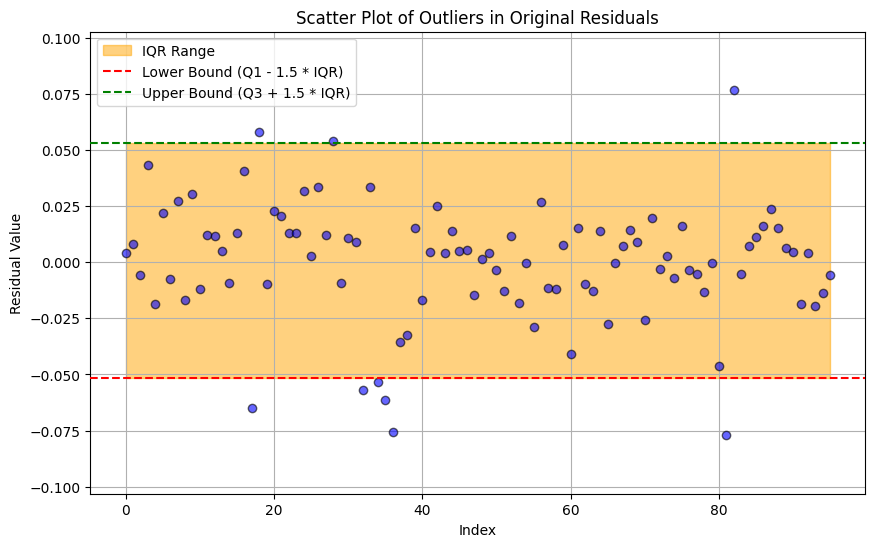

In [9]:
import matplotlib.pyplot as plt
# Calculate the IQR and the thresholds for outliers
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Check the values
print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

# Create scatter plot
plt.figure(figsize=(10, 6))

# Now plot the data points
plt.scatter(range(len(data)), data, alpha=0.6, edgecolor='k', color='blue', zorder=2)

# Check if bounds are within the y-limits of your current data points
plt.ylim(min(data) - IQR, max(data) + IQR)

# Annotate the IQR area with a clearly visible color and higher opacity
plt.fill_between(range(len(data)), lower_bound, upper_bound, color='orange', alpha=0.5, label='IQR Range', zorder=1)

# Adding horizontal lines for the IQR boundaries
plt.axhline(y=lower_bound, color='red', linestyle='--', label='Lower Bound (Q1 - 1.5 * IQR)', zorder=3)
plt.axhline(y=upper_bound, color='green', linestyle='--', label='Upper Bound (Q3 + 1.5 * IQR)', zorder=3)

# Adding labels and title
plt.title('Scatter Plot of Outliers in Original Residuals')
plt.xlabel('Index')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


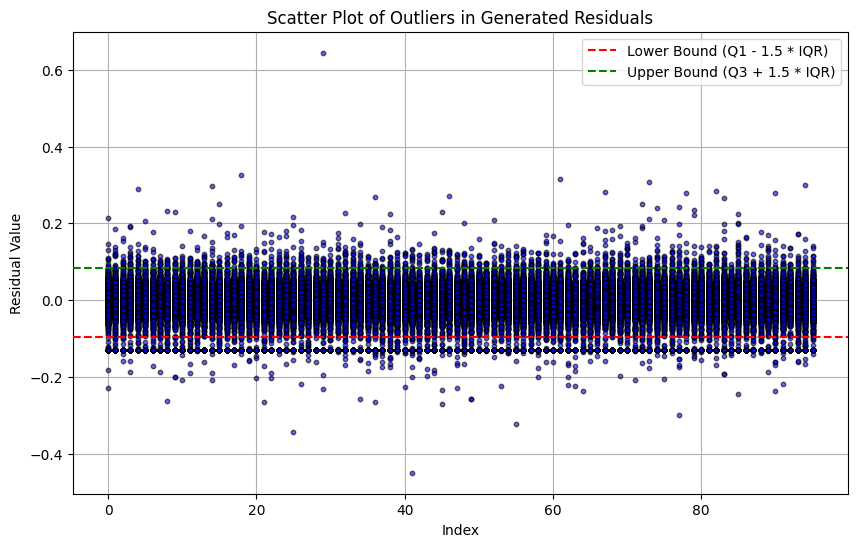

In [10]:
# Assuming 'gen_residuals_df' is a DataFrame or a 2D numpy array with shape (96, 1000)
data = gen_residuals_df.values.flatten()  # Flatten the 2D array to 1D

# Calculate the IQR and the thresholds for outliers for the flattened data
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create scatter plot
plt.figure(figsize=(10, 6))

# Assuming each row in your dataframe is a time point and each column is a different simulation
# You will need to create x-coordinates that match the structure
x_coords = np.repeat(range(gen_residuals_df.shape[0]), gen_residuals_df.shape[1])

# Now plot the data points
plt.scatter(x_coords, data, alpha=0.6, edgecolor='k', color='blue', s=10, zorder=2)

# Annotate the IQR area
plt.axhline(y=lower_bound, color='red', linestyle='--', label='Lower Bound (Q1 - 1.5 * IQR)', zorder=3)
plt.axhline(y=upper_bound, color='green', linestyle='--', label='Upper Bound (Q3 + 1.5 * IQR)', zorder=3)

# Adding labels and title
plt.title('Scatter Plot of Outliers in Generated Residuals')
plt.xlabel('Index')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [11]:
# Parameters from the fitted AR model
const = fitted_model.params['const']
AR = fitted_model.arparams[0]
print('Const:',const)
print('AR:',AR)

# Initialize arrays to store simulated GDP and log growth rates
sim_q_gdp = np.zeros([len(log_gr), 1000])
sim_log_gr = np.zeros([len(log_gr), 1000])

# Perform Monte Carlo simulation
for i in range(1000):
    for t in range(1, len(log_gr)):
        sim_log_gr[t, i] = const + AR * sim_log_gr[t-1, i] + generated_residuals[t, i]
        sim_q_gdp[:, i] = quarter_gdp['Quarter GDP'].iloc[0] * (np.exp(np.cumsum(sim_log_gr[:, i]))) #THIS LINE IS THE KEY
#Assign simulated data to a variable, so it can be reused
sim_q_gdp_df = pd.DataFrame(sim_q_gdp)
# Display the simulated GDP DataFrame
print('Simulated GDP DataFrame:')
display(sim_q_gdp_df)

# Display first value from original dataframe
print('First value from original dataframe:')
display(quarter_gdp['Quarter GDP'].iloc[0])

Const: 0.019621402364078014
AR: 0.262959379954952
Simulated GDP DataFrame:


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,...,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
1,1463.073744,1487.268497,1557.600334,1500.470873,1515.711862,1317.432111,1518.834665,1474.635972,1529.586791,1462.511995,...,1445.746205,1513.302661,1518.527021,1519.782513,1526.759023,1559.909166,1448.097949,1441.640442,1526.874646,1553.262101
2,1410.353212,1463.808082,1413.706185,1348.538250,1536.607056,1430.966326,1566.582876,1519.948329,1543.264036,1529.118325,...,1488.385557,1448.064536,1457.707627,1532.339073,1527.573875,1572.489766,1498.345316,1517.739326,1558.531641,1628.065268
3,1426.872994,1474.569649,1395.428762,1293.443982,1379.278362,1430.946925,1565.369131,1637.833061,1558.879623,1613.063129,...,1509.551641,1404.581459,1519.311556,1517.475477,1529.178578,1610.088768,1586.714706,1587.067441,1625.032659,1725.504748
4,1476.061946,1566.393921,1432.428236,1334.167244,1414.633395,1470.334192,1595.295925,1717.004240,1588.845447,1631.907645,...,1608.776547,1459.149181,1536.028682,1610.898709,1368.055159,1657.542904,1556.500147,1629.846751,1665.531381,1812.827189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,3402.653204,3310.513070,2942.163876,4627.582480,5616.743903,2106.059512,2231.644727,5308.408618,3253.888908,4328.792115,...,2414.753174,3395.563400,4693.002491,2267.030218,2670.063453,2953.890757,2870.621400,6613.375518,2584.649729,3456.086004
92,3401.231315,3462.129982,2636.416849,4722.350757,5897.202639,2240.308059,2296.407719,5580.190014,3605.535901,4348.313664,...,2306.863843,3137.830837,4649.641290,2039.610709,2559.255825,2844.889939,2844.629975,6782.568070,2760.743888,3491.319027
93,3544.954776,3641.074185,2614.704730,4712.032576,6124.155505,2410.028125,2264.302324,5728.767354,3312.948309,4412.687992,...,2391.910232,3223.730496,4538.715380,2000.935855,2621.621567,2519.399936,2837.426138,6106.671809,2792.342807,3687.771594
94,3686.663467,3675.157663,2641.997359,4702.243867,6601.556461,2555.546705,2017.678762,5722.914581,3241.738365,3961.932017,...,2435.162717,2903.812222,4033.675187,2044.184376,2678.425763,2556.724263,2823.038557,6241.915947,2697.162981,3768.651162


First value from original dataframe:


1473

In [12]:
# Create a DatetimeIndex for the DataFrame
index = pd.date_range(start='2000-01-01', periods=len(log_gr), freq='Q')
# Add index
sim_q_gdp_df.index = index
# Display quarterly simulated gdp values
display(sim_q_gdp_df)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2000-03-31,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,...,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
2000-06-30,1463.073744,1487.268497,1557.600334,1500.470873,1515.711862,1317.432111,1518.834665,1474.635972,1529.586791,1462.511995,...,1445.746205,1513.302661,1518.527021,1519.782513,1526.759023,1559.909166,1448.097949,1441.640442,1526.874646,1553.262101
2000-09-30,1410.353212,1463.808082,1413.706185,1348.538250,1536.607056,1430.966326,1566.582876,1519.948329,1543.264036,1529.118325,...,1488.385557,1448.064536,1457.707627,1532.339073,1527.573875,1572.489766,1498.345316,1517.739326,1558.531641,1628.065268
2000-12-31,1426.872994,1474.569649,1395.428762,1293.443982,1379.278362,1430.946925,1565.369131,1637.833061,1558.879623,1613.063129,...,1509.551641,1404.581459,1519.311556,1517.475477,1529.178578,1610.088768,1586.714706,1587.067441,1625.032659,1725.504748
2001-03-31,1476.061946,1566.393921,1432.428236,1334.167244,1414.633395,1470.334192,1595.295925,1717.004240,1588.845447,1631.907645,...,1608.776547,1459.149181,1536.028682,1610.898709,1368.055159,1657.542904,1556.500147,1629.846751,1665.531381,1812.827189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,3402.653204,3310.513070,2942.163876,4627.582480,5616.743903,2106.059512,2231.644727,5308.408618,3253.888908,4328.792115,...,2414.753174,3395.563400,4693.002491,2267.030218,2670.063453,2953.890757,2870.621400,6613.375518,2584.649729,3456.086004
2023-03-31,3401.231315,3462.129982,2636.416849,4722.350757,5897.202639,2240.308059,2296.407719,5580.190014,3605.535901,4348.313664,...,2306.863843,3137.830837,4649.641290,2039.610709,2559.255825,2844.889939,2844.629975,6782.568070,2760.743888,3491.319027
2023-06-30,3544.954776,3641.074185,2614.704730,4712.032576,6124.155505,2410.028125,2264.302324,5728.767354,3312.948309,4412.687992,...,2391.910232,3223.730496,4538.715380,2000.935855,2621.621567,2519.399936,2837.426138,6106.671809,2792.342807,3687.771594
2023-09-30,3686.663467,3675.157663,2641.997359,4702.243867,6601.556461,2555.546705,2017.678762,5722.914581,3241.738365,3961.932017,...,2435.162717,2903.812222,4033.675187,2044.184376,2678.425763,2556.724263,2823.038557,6241.915947,2697.162981,3768.651162


In [13]:
#Load original annual GDP from Eurostat
def load_and_check(annual_gdp):
    if annual_gdp.shape[0] != 24: # number of rows(indexed as [0]) in the created pandas dataframe should match the amount of rows in .csv file
        print('Please check if data was loaded properly, different shape was expected.')
    else:
        print('Data loaded properly.')
    return annual_gdp
url = "https://drive.google.com/uc?id=1CFulC9DNeJ1O44xW-cKUeYDwlfn6aIPG&export=download"
annual_gdp = pd.read_csv(url)
display(load_and_check(annual_gdp))

Data loaded properly.


,Year,Annual GDP
0,2000,6172
1,2001,6987
2,2002,7823
3,2003,8744
4,2004,9778
5,2005,11343
6,2006,13569
7,2007,16401
8,2008,16618
9,2009,14132


In [14]:
# Ensure the index for annual_gdp is set to the Year column and is of datetime type
annual_gdp.set_index(pd.to_datetime(annual_gdp['Year'], format='%Y'), inplace=True)

# Prepare an empty DataFrame with the correct shape: 96 quarters x 1000 simulations
normalized_sim_q_gdp_df = pd.DataFrame(index=sim_q_gdp_df.index, columns=range(sim_q_gdp_df.shape[1]))

# Normalize Quarterly Simulated Values
for i in range(normalized_sim_q_gdp_df.shape[1]):  # iterating over each simulation
    sim_data = sim_q_gdp_df.iloc[:, i]  # get the simulation column
    sim_data_yearly = sim_data.resample('A-DEC').sum()  # sum quarterly data to annual

    for year in sim_data_yearly.index.year:
        if year in annual_gdp.index.year:
            yearly_total = sim_data_yearly[sim_data_yearly.index.year == year].iloc[0]
            annual_gdp_value = annual_gdp.loc[pd.Timestamp(year=year, month=1, day=1)]['Annual GDP']

            # Normalize quarterly values
            quarter_mask = (sim_data.index.year == year)
            normalized_quarters = (sim_data[quarter_mask] / yearly_total) * annual_gdp_value

            # Assign normalized values to the corresponding year and simulation column
            normalized_sim_q_gdp_df.loc[normalized_quarters.index, i] = normalized_quarters.values

# Convert all columns to float
normalized_sim_q_gdp_df = normalized_sim_q_gdp_df.astype(float)

# Now you have the normalized_sim_q_gdp_df DataFrame with correct indexing and shape (96x1000)

# Ensure the index is sorted and set as a datetime index
normalized_sim_q_gdp_df.sort_index(inplace=True)

# Verification by Resampling Annually and Comparing with Actual Annual GDP
resampled_annual_values = normalized_sim_q_gdp_df.resample('A-DEC').sum()

# Create the comparison DataFrame if resampling produced a non-empty DataFrame
if not resampled_annual_values.empty:
    common_years = set(resampled_annual_values.index.year).intersection(set(annual_gdp.index.year))
    resampled_annual_values = resampled_annual_values[resampled_annual_values.index.year.isin(common_years)]
    annual_gdp_filtered = annual_gdp[annual_gdp.index.year.isin(common_years)]

    # Convert common_years set to a sorted list for DataFrame index
    common_years_list = sorted(list(common_years))

    comparison_df = pd.DataFrame({
        'Simulated Normalised Annual GDP': resampled_annual_values.iloc[:, 0].values,
        'Actual Annual GDP': annual_gdp_filtered['Annual GDP'].values
    }, index=common_years_list)

    print(comparison_df)
else:
    print("resampled_annual_values is empty after resampling. Check resample method.")


      Simulated Normalised Annual GDP  Actual Annual GDP
2000                           6172.0               6172
2001                           6987.0               6987
2002                           7823.0               7823
2003                           8744.0               8744
2004                           9778.0               9778
2005                          11343.0              11343
2006                          13569.0              13569
2007                          16401.0              16401
2008                          16618.0              16618
2009                          14132.0              14132
2010                          14741.0              14741
2011                          16677.0              16677
2012                          17917.0              17917
2013                          18911.0              18911
2014                          20048.0              20048
2015                          20631.0              20631
2016                          2

In [15]:
display(normalized_sim_q_gdp_df)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2000-03-31,1574.724348,1541.261443,1556.809609,1618.988856,1539.708056,1608.421888,1484.597111,1489.063804,1489.231355,1495.856294,...,1536.562865,1557.019343,1523.211128,1504.544471,1501.087885,1462.693909,1513.672475,1510.330714,1470.275049,1425.014927
2000-06-30,1564.112592,1556.191168,1646.223467,1649.182364,1584.354219,1438.551693,1530.792638,1490.717617,1546.441690,1485.205548,...,1508.133014,1599.620852,1570.290059,1552.328837,1555.872011,1548.995000,1488.082828,1478.176400,1524.050031,1502.662376
2000-09-30,1507.751216,1531.643556,1494.142141,1482.191717,1606.195698,1562.523802,1578.916777,1536.524127,1560.269648,1552.845398,...,1552.612339,1530.661570,1507.397475,1565.154297,1556.702401,1561.487578,1539.717626,1556.203883,1555.648462,1575.028724
2000-12-31,1525.411844,1542.903833,1474.824783,1421.637062,1441.742027,1562.502617,1577.693475,1655.694452,1576.057307,1638.092759,...,1574.691781,1484.698235,1571.101338,1549.972395,1558.337703,1598.823512,1630.527071,1627.289003,1622.026458,1669.293973
2001-03-31,1597.788009,1673.916751,1733.580519,1789.814739,1609.737197,1871.419895,1663.120251,1709.711826,1716.147232,1670.923202,...,1811.285140,1667.090210,1739.850294,1677.068676,1682.725025,1643.835412,1959.889351,1467.451707,1898.942527,1651.162657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,8637.428952,8395.400554,8731.057392,9028.307356,9277.568016,8939.998444,8241.226958,8589.293221,9286.914274,8291.153258,...,7577.951838,9064.100010,10250.579662,9483.688207,8391.029426,8067.802114,8408.298335,9651.801913,9598.627145,9816.821738
2023-03-31,8883.970685,8844.716503,9559.778620,9325.188713,9016.786766,8861.018723,10389.299327,9493.554961,10091.305699,9811.135829,...,9025.347815,9725.121495,10099.285904,9411.884514,9061.861261,10194.276007,9484.040713,9874.104028,9432.992510,8919.371527
2023-06-30,9259.374443,9301.865932,9481.049397,9304.813483,9363.796309,9532.307065,10244.049618,9746.328995,9272.400850,9956.384153,...,9358.082337,9991.351467,9858.348506,9233.417487,9282.687054,9027.926867,9460.023006,8890.130123,9540.960644,9421.254461
2023-09-30,9629.515647,9388.939121,9580.013829,9285.483797,10093.739451,10107.872043,9128.286945,9736.371696,9073.095854,8939.339746,...,9527.302869,8999.824439,8761.372419,9432.989929,9483.820424,9161.673516,9412.054589,9087.019364,9215.747360,9627.879781


In [16]:
#Load original annual consumption aggregates from Eurostat
def load_and_check(annual_cons):
    if annual_cons.shape[0] != 24: # number of rows(indexed as [0]) in the created pandas dataframe should match the amount of rows in .csv file
        print('Please check if data was loaded properly, different shape was expected.')
    else:
        print('Data loaded properly.')
    return annual_cons
url = "https://drive.google.com/uc?id=1NY4nmAB4zZ3WTAdXTrDSLCyAu0vTJWIA&export=download"
annual_cons = pd.read_csv(url)
display(load_and_check(annual_cons))

Data loaded properly.


,Year,Annual cons agg
0,2000,3636
1,2001,4113
2,2002,4588
3,2003,5043
4,2004,5709
5,2005,6486
6,2006,7591
7,2007,8742
8,2008,8997
9,2009,7753


In [17]:
# Convert the first column to datetime and set as the index
annual_cons.index = pd.to_datetime(annual_cons.iloc[:, 0], format='%Y')
annual_cons.drop(annual_cons.columns[0], axis=1, inplace=True)  # Drop the redundant column if needed
display(annual_cons)

,Annual cons agg
Year,
2000-01-01,3636
2001-01-01,4113
2002-01-01,4588
2003-01-01,5043
2004-01-01,5709
2005-01-01,6486
2006-01-01,7591
2007-01-01,8742
2008-01-01,8997


In [18]:
from statsmodels.tsa.interp.denton import dentonm
# Prepare the DataFrame to store the disaggregated results
disagg_data = pd.DataFrame(index=normalized_sim_q_gdp_df.index, columns=np.arange(1000))

# Disaggregate using the Denton method
for i in range(1000):
    # Benchmark series (quarterly data) for the current simulation
    benchmark = normalized_sim_q_gdp_df.iloc[:, i].values
    # Apply the Denton method
    disagg_series = dentonm(benchmark, annual_cons, freq='aq')
    disagg_data.iloc[:, i] = disagg_series

# 'disagg_data' now contains the disaggregated quarterly data for each simulation
display(disagg_data)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2000-03-31,927.915563,908.197782,917.359525,953.996665,907.278462,947.785037,874.811977,877.443881,877.536878,881.447412,...,905.434969,917.474027,897.568834,886.566032,884.535761,861.907722,891.95896,889.970007,866.388036,839.71636
2000-06-30,921.570891,916.905638,969.950786,971.688886,933.495649,847.596551,901.946357,878.334569,911.16285,875.08697,...,888.593864,942.487248,925.218421,914.634223,916.726265,912.674069,876.789318,870.940681,897.984644,885.384658
2000-09-30,888.186854,902.265041,880.164835,873.11853,946.177953,920.455682,930.11948,905.15096,919.134439,914.764708,...,914.620537,901.682771,887.982242,922.008339,917.028563,919.853181,907.027265,916.74312,916.412859,927.836555
2000-12-31,898.326692,908.631539,868.524854,837.195919,849.047935,920.162731,929.122186,975.07059,928.165833,964.700909,...,927.350629,874.355954,925.230503,912.791407,917.709412,941.565028,960.224457,958.346192,955.214461,983.062426
2001-03-31,940.582688,985.400518,1020.503748,1053.60273,947.611501,1101.635302,979.039221,1006.48393,1010.273849,983.643582,...,1066.255562,981.39801,1024.193842,987.24427,990.553395,967.681326,1153.701431,863.880885,1117.813106,971.971174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,4420.662928,4296.558224,4467.326728,4619.68695,4744.088416,4573.533408,4217.587678,4394.587348,4750.753368,4242.96085,...,3879.476788,4636.290172,5239.290547,4849.185955,4293.458467,4128.798242,4302.019166,4934.538207,4908.931442,5019.866063
2023-03-31,4580.113592,4559.6742,4929.093912,4807.691918,4647.030942,4567.618309,5359.279014,4894.986546,5203.252668,5059.708381,...,4653.851174,5014.169414,5205.839781,4850.871004,4671.500633,5257.305876,4889.776481,5089.206013,4862.424068,4596.617637
2023-06-30,4800.152761,4822.040348,4916.437235,4824.289715,4854.542354,4942.027073,5314.617988,5054.3085,4808.601868,5163.814596,...,4851.752467,5181.745859,5112.997086,4787.151595,4812.411236,4681.813142,4905.283243,4609.307651,4947.04466,4884.019674
2023-09-30,5010.736268,4885.431475,4986.467143,4832.439208,5253.782568,5260.567542,4752.606215,5068.091115,4723.168305,4653.18268,...,4957.537704,4685.062397,4561.959282,4910.064525,4935.37245,4768.897253,4898.849478,4730.339258,4796.948824,5010.895861


In [19]:
#Load original quarterly consumption aggregats from Eurostat
def load_and_check(quarterly_cons):
    if quarterly_cons.shape[0] != 96: # number of rows(indexed as [0]) in the created pandas dataframe should match the amount of rows in .csv file
        print('Please check if data was loaded properly, different shape was expected.')
    else:
        print('Data loaded properly.')
    return quarterly_cons
url = "https://drive.google.com/uc?id=1SxgMVn8YCA9tGB3e6fzTt8tT5TetY4xL&export=download"
quarterly_cons = pd.read_csv(url)
display(load_and_check(quarterly_cons))

Data loaded properly.


,Quarter,Quarter cons agg
0,2000-Q1,871
1,2000-Q2,903
2,2000-Q3,911
3,2000-Q4,949
4,2001-Q1,986
...,...,...
91,2022-Q4,4747
92,2023-Q1,4832
93,2023-Q2,4863
94,2023-Q3,4877


In [20]:
# Convert the first column to datetime and set as the index
index = pd.date_range(start='2000-01-01', periods=len(quarterly_cons), freq='Q')  # Drop the redundant column if needed
quarterly_cons.index = index
quarterly_cons.drop(quarterly_cons.columns[0], axis=1, inplace=True)
display(quarterly_cons)

,Quarter cons agg
2000-03-31,871
2000-06-30,903
2000-09-30,911
2000-12-31,949
2001-03-31,986
...,...
2022-12-31,4747
2023-03-31,4832
2023-06-30,4863
2023-09-30,4877


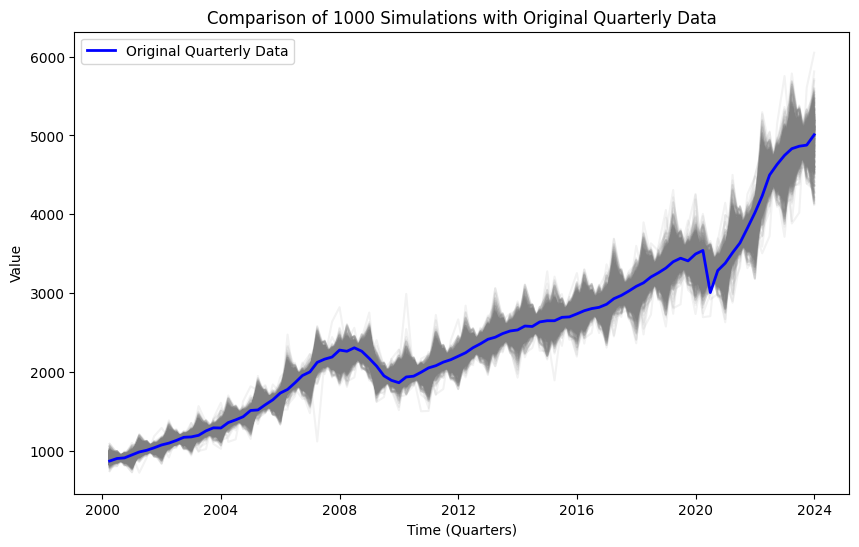

In [24]:
plt.figure(figsize=(10, 6))
# Plot each simulation scenario
for i in range(disagg_data.shape[1]):  # disagg_data.shape[1] is 1000, representing the number of columns
    plt.plot(quarterly_cons.index, disagg_data.iloc[:, i], color='grey', alpha=0.1)  # alpha controls the transparency

# Plot the original quarterly data
plt.plot(quarterly_cons.index, quarterly_cons['Quarter cons agg'], label='Original Quarterly Data', color='blue', linewidth=2)

# Add plot title and labels
plt.title('Comparison of 1000 Simulations with Original Quarterly Data')
plt.xlabel('Time (Quarters)')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show plot
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ensure that the lengths of both datasets are the same
if len(disagg_data) != len(quarterly_cons):
    raise ValueError("The lengths of disaggregated data and true GDP data do not match.")

# Initialize arrays to store the metrics for each column and simulation
num_simulations = 1000
mae_values = np.zeros((num_simulations,))
rmse_values = np.zeros((num_simulations,))
mape_values = np.zeros((num_simulations,))
smape_values = np.zeros((num_simulations,))

true_gdp_values = quarterly_cons['Quarter cons agg'].values

# Calculate the metrics for each column of disaggregated data for each simulation
for i in range(num_simulations):
    disagg_column = disagg_data.iloc[:, i]

    # Calculate MAE
    mae_values[i] = mean_absolute_error(true_gdp_values, disagg_column)

    # Calculate RMSE
    rmse_values[i] = np.sqrt(mean_squared_error(true_gdp_values, disagg_column))

    # Calculate MAPE and sMAPE (avoiding division by zero)
    eps = 1e-10  # Small constant to avoid division by zero
    mape_values[i] = np.mean(np.abs((true_gdp_values - disagg_column) / (true_gdp_values + eps)))
    smape_values[i] = np.mean(np.abs(true_gdp_values - disagg_column) / (np.abs(true_gdp_values) + np.abs(disagg_column) + eps))

# Compute the mean of all simulations' error metrics
mean_mae = np.mean(mae_values)
mean_rmse = np.mean(rmse_values)
mean_mape = np.mean(mape_values)
mean_smape = np.mean(smape_values)

# Print the mean error metrics
print("Mean MAE across all simulations:", mean_mae)
print("Mean RMSE across all simulations:", mean_rmse)
print("Mean MAPE across all simulations:", mean_mape)
print("Mean sMAPE across all simulations:", mean_smape)

Mean MAE across all simulations: 97.59832937571689
Mean RMSE across all simulations: 141.3367073274104
Mean MAPE across all simulations: 0.039954811656074
Mean sMAPE across all simulations: 0.019958864707339506
